## LAB 2.2 A2: Transfer Learning & Finetuning with Tensorflow

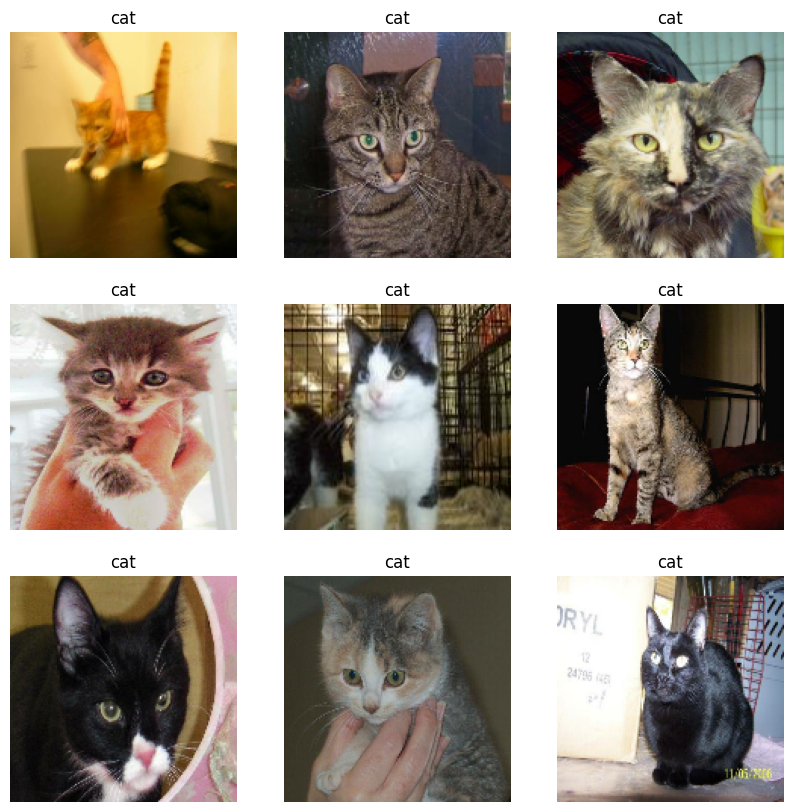

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pathlib
import os

warnings.filterwarnings("ignore")

data_dir = pathlib.Path("data/dog_vs_cat")
all_images = list(data_dir.glob("*.jpg"))
img_height, img_width = 150, 150
batch_size = 128

file_paths = [str(p) for p in all_images]
labels = [0 if os.path.basename(p).startswith("cat") else 1 for p in file_paths]

dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    return img, label

dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_size = int(0.8 * len(file_paths))
val_size = int(0.1 * len(file_paths))

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

class_names = ["cat", "dog"]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    include_top=False,
)
base_model.trainable = False

inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./127.5, offset=-1)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [3]:
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=2, validation_data=val_ds)

base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=2, validation_data=val_ds)

loss, acc = model.evaluate(val_ds)
print("Validation accuracy:", acc)

Fitting the top layer of the model
Epoch 1/2
157/157 [==============================] - 121s 720ms/step - loss: 0.2818 - binary_accuracy: 0.8630 - val_loss: 0.1607 - val_binary_accuracy: 0.9176
Epoch 2/2
157/157 [==============================] - 110s 698ms/step - loss: 0.1481 - binary_accuracy: 0.9382 - val_loss: 0.1020 - val_binary_accuracy: 0.9512
Fitting the end-to-end model
Epoch 1/2
157/157 [==============================] - 173s 1s/step - loss: 0.1069 - binary_accuracy: 0.9589 - val_loss: 0.0555 - val_binary_accuracy: 0.9740
Epoch 2/2
20/20 [==============================] - 3s 125ms/step - loss: 0.0657 - binary_accuracy: 0.9692
Validation accuracy: 0.9692000150680542


### Note:

I did read the instructions but I don't think 10 epochs is necessary